### First bring in the necessary import statements to EDA and initial modeling to examine the data.

In [337]:
import re
import nltk
import spacy
import string
import numpy as np
import pandas as pd
import seaborn as sns
import texthero as hr
from PIL import Image 
from wordcloud import WordCloud
from nltk import pos_tag, FreqDist
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from sklearn.manifold import TSNE
from collections import defaultdict
from mpl_toolkits.mplot3d import Axes3D
from nltk.tokenize import TweetTokenizer
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from sklearn.dummy import DummyClassifier
from nltk.corpus import stopwords, wordnet
from sklearn.feature_extraction import text
from sklearn.compose import ColumnTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline, make_pipeline
from imblearn.pipeline import Pipeline as imbPipeline
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.tokenize import word_tokenize, regexp_tokenize, RegexpTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, StackingClassifier, AdaBoostClassifier
from sklearn.metrics import plot_roc_curve, plot_confusion_matrix, confusion_matrix, classification_report, accuracy_score, precision_score

import os
import sys
sys.setrecursionlimit(100000)
module_path = os.path.abspath(os.pardir)
print(module_path)
if module_path not in sys.path:
    sys.path.append(module_path)
%matplotlib inline
pd.set_option('display.max_colwidth', None)

/Users/jax/Documents/Flatiron


In [338]:
#nltk.download('averaged_perceptron_tagger')
#!pip install TextHero

# Initial Exploratory Analysis

### -Bring in the data and examine our observations.

In [339]:
org_df = pd.read_csv('data/GW_Sentiment_Tweets.csv')

In [340]:
org_df.count()

tweet                   6027
existence               4187
existence_confidence    6024
dtype: int64

In [341]:
org_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6027 entries, 0 to 6026
Data columns (total 3 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   tweet                 6027 non-null   object 
 1   existence             4187 non-null   object 
 2   existence_confidence  6024 non-null   float64
dtypes: float64(1), object(2)
memory usage: 141.4+ KB


In [342]:
org_df

,tweet,existence,existence_confidence
0,"Global warming report urges governments to act|BRUSSELS, Belgium (AP) - The world faces increased hunger and .. [link]",Yes,1.0000
1,Fighting poverty and global warming in Africa [link],Yes,1.0000
2,Carbon offsets: How a Vatican forest failed to reduce global warming [link],Yes,0.8786
3,Carbon offsets: How a Vatican forest failed to reduce global warming [link],Yes,1.0000
4,URUGUAY: Tools Needed for Those Most Vulnerable to Climate Change [link],Yes,0.8087
...,...,...,...
6022,"@bloodless_coup ""The phrase 'global warming' should be abandoned in favor of 'climate change', Luntz says,"" http://bit.ly/7bIY0c #p2 #tcot",Y,1.0000
6023,Virginia to Investigate Global Warming Scientist Mann: http://bit.ly/aDlavg,NaN,1.0000
6024,Global warming you tube parody you will enjoy #IPCC #ocra http://bit.ly/bBGWhC,N,0.6411
6025,One-Eyed Golfer: Don't dare tell me about global warming: Twenty-five of the forty-nine golfers making the cut thi... http://bit.ly/akeAxp,N,1.0000


### From here you can already see there are duplicate rows of tweets strangely with different existence values.

In [343]:
num_unique = (~org_df.tweet.duplicated()).sum()
num_unique

5481

In [344]:
num_duplicate = org_df.tweet.duplicated().sum()
num_duplicate

546

### There are 5481 tweets that are not duplicates. Let's extract the duplicate rows.

In [345]:
org_df.loc[org_df.tweet.duplicated(), :]

,tweet,existence,existence_confidence
3,Carbon offsets: How a Vatican forest failed to reduce global warming [link],Yes,1.0000
94,"Plants effective way of tackling global warming|Washington, Apr 30 : Plant leaves account for less than one per .. [link]",Yes,0.7925
111,"CLIMATE CHANGE: Forests Not for Absorbing Carbon, Say Activists [link]",NaN,0.6135
112,"CLIMATE CHANGE: Forests Not for Absorbing Carbon, Say Activists [link]",Yes,0.5763
114,"CLIMATE CHANGE: Forests Not for Absorbing Carbon, Say Activists [link]",Yes,0.8243
...,...,...,...
5840,"Global warming ballot initiative: Teamsters and cities weigh in: The California Teamsters, one of the state's most... http://bit.ly/aMYbOS",NaN,0.6346
5903,"http://theclimatedesk.org/ launches, backed by Wired, Atlantic, Mother Jones, Slate, CIR, NPR, to report climate change impacts, responses",Y,0.6424
5999,Natural Resource Econ: Krugman on Climate Change http://bit.ly/b4IyRj,Y,0.6436
6003,"Valero Gas wants to kill AB 32, CA's global warming law. Join @CredoAction & @CourageCampaign to stop them: http://BoycottValero.com Pls RT",NaN,0.7674


In [346]:
unique_df=org_df.drop_duplicates(subset='tweet', keep='first').copy()

In [347]:
unique_df.tweet.duplicated().sum()

0

In [348]:
unique_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5481 entries, 0 to 6026
Data columns (total 3 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   tweet                 5481 non-null   object 
 1   existence             3822 non-null   object 
 2   existence_confidence  5478 non-null   float64
dtypes: float64(1), object(2)
memory usage: 171.3+ KB


### Now all our duplicates have been removed and we can continue onto our preprocessing of the tweets. First let's create our target.

In [349]:
le = LabelEncoder()
le.fit(unique_df['existence'])
unique_df['target'] = le.transform(unique_df['existence'])
unique_df.target.value_counts()

2    2371
4    1659
0     981
3     429
1      41
Name: target, dtype: int64

### Well crap. Got 5 different classes for some odd reason so let's further analyze.

In [350]:
unique_df.existence.value_counts()

Y      2371
N       981
Yes     429
No       41
Name: existence, dtype: int64

### Strangely we have Y, Yes and N, No so let's consolodate those.

In [351]:
unique_df.replace('Y', 'Yes', inplace=True)
unique_df.replace('N', 'No', inplace=True)
unique_df.existence.value_counts()

Yes    2800
No     1022
Name: existence, dtype: int64

In [352]:
le.fit(unique_df['existence'])
unique_df['target'] = le.transform(unique_df['existence'])
unique_df.target.value_counts()

1    2800
2    1659
0    1022
Name: target, dtype: int64

### There we go that's better so now we can drop the column existence.

In [353]:
unique_df.drop(columns=['existence'], axis=1, inplace=True)
unique_df

,tweet,existence_confidence,target
0,"Global warming report urges governments to act|BRUSSELS, Belgium (AP) - The world faces increased hunger and .. [link]",1.0000,1
1,Fighting poverty and global warming in Africa [link],1.0000,1
2,Carbon offsets: How a Vatican forest failed to reduce global warming [link],0.8786,1
4,URUGUAY: Tools Needed for Those Most Vulnerable to Climate Change [link],0.8087,1
5,RT @sejorg: RT @JaymiHeimbuch: Ocean Saltiness Shows Global Warming Is Intensifying Our Water Cycle [link],1.0000,1
...,...,...,...
6022,"@bloodless_coup ""The phrase 'global warming' should be abandoned in favor of 'climate change', Luntz says,"" http://bit.ly/7bIY0c #p2 #tcot",1.0000,1
6023,Virginia to Investigate Global Warming Scientist Mann: http://bit.ly/aDlavg,1.0000,2
6024,Global warming you tube parody you will enjoy #IPCC #ocra http://bit.ly/bBGWhC,0.6411,0
6025,One-Eyed Golfer: Don't dare tell me about global warming: Twenty-five of the forty-nine golfers making the cut thi... http://bit.ly/akeAxp,1.0000,0


### Now let's make a bunch of functions to speed up preprocessing juuuuust in case we need to use this again. We're going to remove punctuation, link, numbers etc.

In [354]:
#Function to clean tweet text
def clean_tweet(tweet):
    #remove links
    tweet_http= re.sub(r"http\S+",' ', tweet)
    # remove RTs
    tweet_rt = re.sub(r'RT[\s]+', '', tweet_http) 
    # remove [VIDEO] text
    tweet_v = re.sub(r'\[VIDEO\]', '', tweet_rt) 
    # remove {link} text
    tweet_l = re.sub(r'\{link\}', '', tweet_v) 
    # remove numbers re.sub(pattern, repl, string, count=0, flags=0)
    tweet_nonum = re.sub(r'\d+', ' ', tweet_l)
    # remove punctuations and lower case
    tweet_nopunct = ''.join([char.lower() for char in tweet_nonum if char not in string.punctuation])
    # substitute multiple whitespace with single whitespace
    cleaned_tweet = re.sub('\s+',' ', tweet_nopunct).strip()
    return cleaned_tweet

In [355]:
#Function to initialize the word tags for lemmatizing
def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

#Tokenizing and lemmatizing
def lema(tweet):
    lem = WordNetLemmatizer()
    tt = TweetTokenizer(strip_handles=True)
    cusstopwords = text.ENGLISH_STOP_WORDS.union(['link', 'climate', 'change', 'global','warm', 'warming'])
    lem_tweet = ' '.join([lem.lemmatize(w, get_wordnet_pos(w)) for w in tt.tokenize(tweet)if w not in cusstopwords])
    return lem_tweet

## Applying our text processing functions

In [356]:
unique_df['clean_tweets'] = [clean_tweet(i) for i in unique_df['tweet']]
unique_df['lemmed_tweets'] = [lema(i) for i in unique_df['clean_tweets']]
unique_df

,tweet,existence_confidence,target,clean_tweets,lemmed_tweets
0,"Global warming report urges governments to act|BRUSSELS, Belgium (AP) - The world faces increased hunger and .. [link]",1.0000,1,global warming report urges governments to actbrussels belgium ap the world faces increased hunger and link,report urge government actbrussels belgium ap world face increase hunger
1,Fighting poverty and global warming in Africa [link],1.0000,1,fighting poverty and global warming in africa link,fight poverty africa
2,Carbon offsets: How a Vatican forest failed to reduce global warming [link],0.8786,1,carbon offsets how a vatican forest failed to reduce global warming link,carbon offset vatican forest fail reduce
4,URUGUAY: Tools Needed for Those Most Vulnerable to Climate Change [link],0.8087,1,uruguay tools needed for those most vulnerable to climate change link,uruguay tool need vulnerable
5,RT @sejorg: RT @JaymiHeimbuch: Ocean Saltiness Shows Global Warming Is Intensifying Our Water Cycle [link],1.0000,1,sejorg jaymiheimbuch ocean saltiness shows global warming is intensifying our water cycle link,sejorg jaymiheimbuch ocean saltiness show intensify water cycle
...,...,...,...,...,...
6022,"@bloodless_coup ""The phrase 'global warming' should be abandoned in favor of 'climate change', Luntz says,"" http://bit.ly/7bIY0c #p2 #tcot",1.0000,1,bloodlesscoup the phrase global warming should be abandoned in favor of climate change luntz says p tcot,bloodlesscoup phrase abandon favor luntz say p tcot
6023,Virginia to Investigate Global Warming Scientist Mann: http://bit.ly/aDlavg,1.0000,2,virginia to investigate global warming scientist mann,virginia investigate scientist mann
6024,Global warming you tube parody you will enjoy #IPCC #ocra http://bit.ly/bBGWhC,0.6411,0,global warming you tube parody you will enjoy ipcc ocra,tube parody enjoy ipcc ocra
6025,One-Eyed Golfer: Don't dare tell me about global warming: Twenty-five of the forty-nine golfers making the cut thi... http://bit.ly/akeAxp,1.0000,0,oneeyed golfer dont dare tell me about global warming twentyfive of the fortynine golfers making the cut thi,oneeyed golfer dont dare tell twentyfive fortynine golfer make cut thi


### Oh that's beautiful now we can drop our clean tweets and tweet column

In [357]:
unique_df.drop(columns=['clean_tweets','tweet'], axis=1, inplace=True)

In [358]:
unique_df

,existence_confidence,target,lemmed_tweets
0,1.0000,1,report urge government actbrussels belgium ap world face increase hunger
1,1.0000,1,fight poverty africa
2,0.8786,1,carbon offset vatican forest fail reduce
4,0.8087,1,uruguay tool need vulnerable
5,1.0000,1,sejorg jaymiheimbuch ocean saltiness show intensify water cycle
...,...,...,...
6022,1.0000,1,bloodlesscoup phrase abandon favor luntz say p tcot
6023,1.0000,2,virginia investigate scientist mann
6024,0.6411,0,tube parody enjoy ipcc ocra
6025,1.0000,0,oneeyed golfer dont dare tell twentyfive fortynine golfer make cut thi


## Let's look at some quick visualizations of our most frequent words

In [359]:
data_pos = unique_df['lemmed_tweets'].loc[unique_df['target'] == 1]
data_na = unique_df['lemmed_tweets'].loc[unique_df['target'] == 2]
data_neg = unique_df['lemmed_tweets'].loc[unique_df['target'] == 0]

In [360]:
believer =[]
for i in data_pos:
    ToStr = ''.join(map(str, i))
    believer.append(ToStr)
believer = ''.join(map(str, believer))

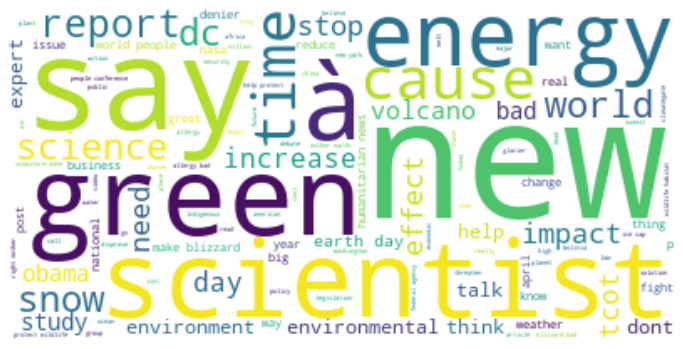

In [361]:
wc = WordCloud(background_color='white', max_words=200)
# generate the word cloud
wc.generate(believer)

plt.figure(figsize=(12,10))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

In [362]:
disbeliever = []
for i in data_neg:
    ToStr = ''.join(map(str, i))
    disbeliever.append(ToStr)
disbeliever = ''.join(map(str, disbeliever))

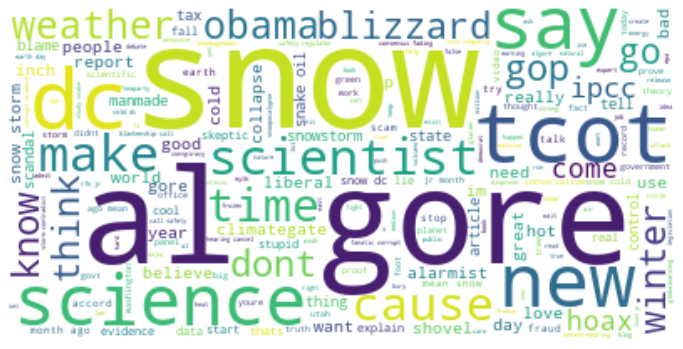

In [363]:
wc = WordCloud(background_color='white', max_words=200)
# generate the word cloud
wc.generate(disbeliever)

plt.figure(figsize=(12,10))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

# Now onto the Good Stuff

### First model I'd like to use naive bayes which is particularly successful with nlp because it assumes *naively* there is no interdependence amongst the variable. Also Multinomial Bayes allows me to train my model with less data and potentionally mislabeled data. So first let's split our data.

In [383]:
y = unique_df['target'].copy()
X = unique_df.drop(columns=['target','existence_confidence'], axis=1).copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=1, stratify=y)
X_t, X_val, y_t, y_val = train_test_split(X, y, test_size=.25, random_state=2, stratify=y)

In [388]:
X_train

,lemmed_tweets
3601,lward snow cover washington dc hand obama promise end do year climategate tcot fb
411,italy phd programme science management phd programme science management c
5949,debate discourage consider human intelligence gw nutcase remain unpersuaded logic evidence
1170,china key fix warmingwith rapid expansion come sizable environmental impact world
591,iceland volcano unlikely slow scientist afp paris • à big volcanic eruption cool
...,...
3569,scientific consensus melt way faster glacier tcot
2577,look great medium material human impact check witness story wwf
3547,naomi klein cspan cause island extinction year
1215,report identifies disease health issue affctd u inclde mental health evrythings stake


In [389]:
y_train

3601    1
411     2
5949    0
1170    1
591     1
       ..
3569    2
2577    1
3547    1
1215    1
3486    0
Name: target, Length: 4110, dtype: int64

In [390]:
#Pipeline setup for Gridsearch
tf_params = {
 'tfidf__max_features':[100, 500, 2000, None],
 'tfidf__ngram_range': [(1, 1), (1, 2), (2, 2), None],
 #'tfidf__min_df':[.1, .2, None],
 #'tfidf__max_df':[.85, .95, None],
 'tfidf__stop_words': [None, 'english']}

rf_params = {
 'tf__max_features':[100, 500, 2000],
 'tf__ngram_range': [(1, 2)],
 'tf__stop_words': ['english'],
 'rf__max_depth': [100, 1000],
 'rf__min_samples_split': [100],
 'rf__max_leaf_nodes': [None]}

mnb_pipe = Pipeline([('tfidf', TfidfVectorizer()),
                    ('mnb', MultinomialNB())])

rf_pipe = Pipeline([('tf',  TfidfVectorizer()),
                     ('rf', RandomForestClassifier())])

In [391]:
rf_gs = GridSearchCV(rf_pipe, param_grid=rf_params, cv = 5, verbose = 1, n_jobs = -1)
#rf_gs.fit(X_train, y_train)

In [392]:
tf_gs = GridSearchCV(mnb_pipe, param_grid=tf_params, cv = 5, verbose = 1, n_jobs = -1)
#tf_gs.fit(X_train, y_train)

## Now that we have picked the best model lets get our predictions

In [368]:
# Fit the vectorizer on X_train["text"] and transform it
#tfidf = TfidfVectorizer(max_features=100)
#X_train_vectorized = tfidf.fit_transform(X_train['lemmed_tweets'])
#vectorized_df = pd.DataFrame(X_train_vectorized.toarray(), columns=tfidf.get_feature_names())
#vectorized_df


In [411]:
deer=tfidf.fit(X_train['lemmed_tweets'])
deer.transform(X_train)
deer.vocabulary_

{'snow': 78,
 'washington': 94,
 'dc': 25,
 'obama': 66,
 'do': 27,
 'year': 99,
 'climategate': 18,
 'tcot': 86,
 'science': 74,
 'debate': 26,
 'come': 22,
 'environmental': 33,
 'impact': 51,
 'world': 98,
 'volcano': 92,
 'scientist': 75,
 'people': 67,
 'issue': 53,
 'blame': 8,
 'call': 13,
 'energy': 31,
 'day': 24,
 'need': 63,
 'snowstorm': 79,
 'real': 70,
 'globalwarming': 38,
 'carbon': 14,
 'say': 73,
 'law': 56,
 'california': 12,
 'april': 5,
 'new': 64,
 'earth': 29,
 'report': 71,
 'health': 47,
 'fight': 36,
 'want': 93,
 'know': 55,
 'effect': 30,
 'air': 2,
 'news': 65,
 'conference': 23,
 'right': 72,
 'immigration': 50,
 'senate': 76,
 'government': 43,
 'cause': 15,
 'policy': 68,
 'believe': 7,
 'climatechange': 17,
 'video': 91,
 'make': 60,
 'bad': 6,
 'great': 45,
 'green': 46,
 'claim': 16,
 'dont': 28,
 'federal': 35,
 'agency': 1,
 'graham': 44,
 'just': 54,
 'look': 59,
 'winter': 97,
 'allergy': 4,
 'action': 0,
 'help': 48,
 'stop': 81,
 'senator': 77,


In [412]:
X_t_vec = tfidf.fit_transform(X_train['lemmed_tweets'])
X_t_vec = pd.DataFrame.sparse.from_spmatrix(X_t_vec)
X_t_vec.columns = sorted(tfidf.vocabulary_)
X_t_vec.set_index(y_t.index, inplace=True)
X_t_vec

,action,agency,air,al,allergy,april,bad,believe,blame,blizzard,...,use,video,volcano,want,washington,way,weather,winter,world,year
1384,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.383548,0.000000,0.0,0.0,0.000000,0.383548
1402,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000
2277,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000
5669,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.436766,0.000000
4298,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.738926,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3503,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.607029,0.0,0.0,0.000000,0.000000
4899,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000
3131,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.750493
1329,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000


In [413]:
X_val_vec = tfidf.fit_transform(X_val)
X_val_vec = pd.DataFrame.sparse.from_spmatrix(X_val_vec)
X_val_vec

,0
0,1.0


In [399]:
X_val_vec = pd.DataFrame.sparse.from_spmatrix(X_val_vec)
X_val_vec.columns = sorted(tfidf.vocabulary_)
#X_val_vec.set_index(y_val.index, inplace=True)
X_val_vec

,action,agency,air,al,allergy,april,bad,believe,blame,blizzard,...,use,video,volcano,want,washington,way,weather,winter,world,year
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [379]:
#y_hat = mnb.predict(X_val_vec)
#accuracy_score(y_val, y_hat)
mnb = MultinomialNB()

mnb.fit(X_t_vec, y_t)

MultinomialNB()

In [382]:
mnb = MultinomialNB()
mnb.fit(X_t_vec, y_t)
y_pred=mnb.predict(X_val_vec)
print(accuracy_score(y_test,y_pred))

ValueError: Found input variables with inconsistent numbers of samples: [1371, 1]

In [ ]:
#vectorized_df.head()
X_train['tfidf'] = tfidf.fit_transform(X_train['lemmed_tweets']).copy()
X_test['tfidf'] = tfidf_vectorizer.transform(X_test)

In [309]:
def classify(self, input):
    input_text = input_vectorizer(max_features=100)
    input_counts = input_vectorizer.transform(input_text)
    predictions = self.classifier.predict(input_counts)
    print(predictions)

In [328]:
idf_values = dict(zip(tfidf.get_feature_names(), tfidf.idf_))
idf_values

{'action': 5.560221471204316,
 'agency': 5.278370319063328,
 'air': 5.514759097127559,
 'al': 4.964712760208286,
 'allergy': 5.537231952979617,
 'april': 5.429601288787252,
 'bad': 4.706301070056619,
 'believe': 5.514759097127559,
 'blame': 5.260978576351459,
 'blizzard': 4.855513468243295,
 'blog': 5.492780190408784,
 'bolivia': 5.514759097127559,
 'california': 5.351129673345756,
 'call': 5.227077024675777,
 'carbon': 5.260978576351459,
 'cause': 4.602922715602784,
 'claim': 5.537231952979617,
 'climatechange': 4.9393949522239975,
 'climategate': 5.370177868316451,
 'clinical': 5.429601288787252,
 'cochabamba': 5.560221471204316,
 'cold': 5.351129673345756,
 'come': 5.278370319063328,
 'conference': 4.964712760208286,
 'day': 4.778126804627874,
 'dc': 4.37266169651971,
 'debate': 5.260978576351459,
 'do': 5.030962145749487,
 'dont': 5.429601288787252,
 'earth': 4.736454108227306,
 'effect': 5.351129673345756,
 'energy': 4.4851396799464,
 'environment': 5.514759097127559,
 'environmen

In [23]:
unique_df.target.value_counts(normalize=True)

1    0.510856
2    0.302682
0    0.186462
Name: target, dtype: float64

In [ ]:
pattern = "([a-zA-Z]+(?:'[a-z]+)?)"

In [ ]:

example_freq_dist = FreqDist(unique_df.iloc[100]['new_tweets'][:20])
example_freq_dist

In [ ]:
X

In [ ]:
X = unique_df.drop('tweet', axis=1).copy()

In [ ]:
y = unique_df['target'].copy()
X = X.drop('target', axis=1).copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, stratify=y)
model=MultinomialNB()
#model.fit(X_train,y_train)
#y_pred=model.predict(X_test)
#print(accuracy_score(y_test,y_pred))
#print(X_train.toarray()[:2])